# SSM test-set exploration and inference

Update `SSM_CHECKPOINT_PATH` to point to your saved State Space Model checkpoint, then run the notebook to visualize a sample and see predicted species scores.


In [10]:
%load_ext autoreload
%autoreload 2
    
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import sys


import torch
from PIL import Image
from torchvision.models import ResNet18_Weights, ResNet50_Weights
ROOT = Path.cwd().parent

print(ROOT)
sys.path.append(str(ROOT))

from src.models.ssm.ssm import StateSpaceModel



TEST_SET_PATH = ROOT / "data/validation_set.npz"
SSM_CHECKPOINT_PATH = ROOT / "checkpoints/epoch195_best.pt"  # <-- update this
BACKBONE = "resnet18"  # set to the backbone used during training ("resnet18" or "resnet50")
SAMPLE_INDEX = 0
TOP_K = 5
PREDICTION_THRESHOLD = 0.42016854191620334

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/scanton/IPEO-2025
Using device: cuda


In [11]:
npz = np.load(TEST_SET_PATH)
env = npz["env"]
landsat = npz["landsat"]
images = npz["images"]
labels = npz["labels"]

sample_idx = int(np.clip(SAMPLE_INDEX, 0, env.shape[0] - 1))

try:
    import pandas as pd

    env_cols = (
        pd.read_csv(ROOT / "data" / "env_variables_test.csv")
        .drop(columns=["surveyId", "Bio3", "Bio5", "Bio6"])
        .columns.tolist()
    )
except Exception:
    env_cols = [f"env_{i}" for i in range(env.shape[1])]

ts_channels = [f"c{i}" for i in range(landsat.shape[2])]

print(f"Loaded test set from {TEST_SET_PATH}")
print(f"env: {env.shape}, landsat: {landsat.shape}, images: {images.shape}, labels: {labels.shape}")
print(f"Sample index in use: {sample_idx}")


Loaded test set from /home/scanton/IPEO-2025/data/validation_set.npz
env: (1000, 18), landsat: (1000, 40, 7), images: (1000, 3, 128, 128), labels: (1000, 342)
Sample index in use: 0


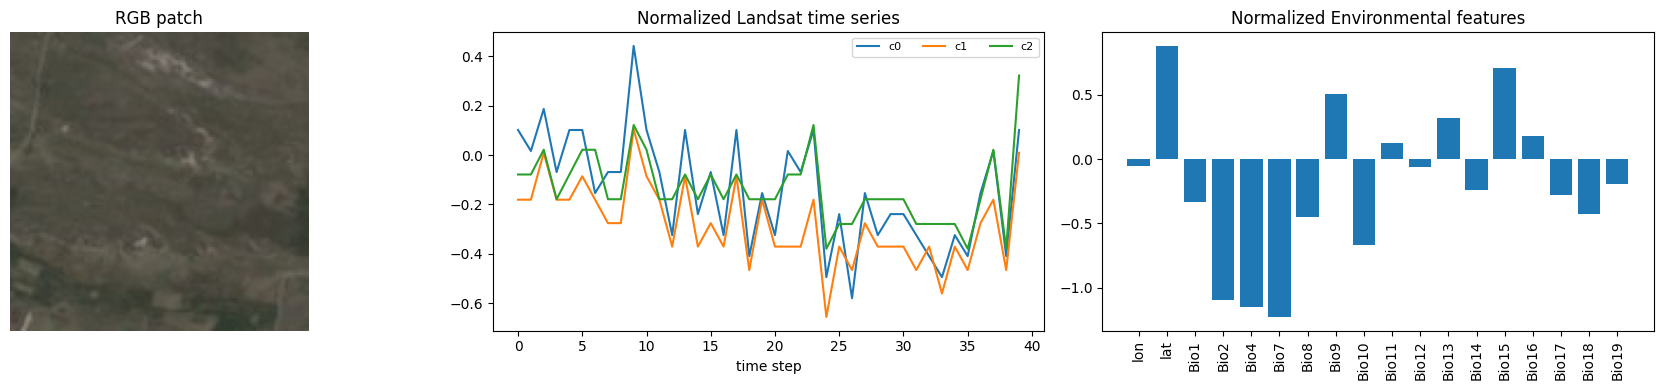

Positive species indices (9 total): [45, 49, 111, 140, 159, 160, 183, 272, 307]


In [12]:
sample_env = env[sample_idx]
sample_ts = landsat[sample_idx]
sample_img = images[sample_idx]
sample_labels = labels[sample_idx]

img_hwc = np.transpose(sample_img, (1, 2, 0))

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

axes[0].imshow(img_hwc)
axes[0].axis("off")
axes[0].set_title("RGB patch")

for i in range(3):
    axes[1].plot(sample_ts[:, i], label=ts_channels[i])
axes[1].set_title("Normalized Landsat time series")
axes[1].set_xlabel("time step")
axes[1].legend(ncol=3, fontsize=8)

axes[2].bar(range(sample_env.shape[0]), sample_env)
axes[2].set_xticks(range(len(env_cols)))
axes[2].set_xticklabels(env_cols, rotation=90)
axes[2].set_title("Normalized Environmental features")

plt.tight_layout()
plt.show()

positive_indices = np.nonzero(sample_labels)[0].tolist()
preview = positive_indices[:20]
more = "..." if len(positive_indices) > len(preview) else ""
print(f"Positive species indices ({len(positive_indices)} total): {preview}{more}")


In [13]:
def build_image_transform(backbone: str):
    if backbone == "resnet18":
        weights = ResNet18_Weights.DEFAULT
    else:
        weights = ResNet50_Weights.DEFAULT
    return weights.transforms(), weights


def preprocess_image(img_array: np.ndarray, transform):
    img_hwc = np.transpose(img_array, (1, 2, 0))
    img_pil = Image.fromarray(img_hwc)
    if img_pil.mode != "RGB":
        img_pil = img_pil.convert("RGB")
    return transform(img_pil)


def load_ssm_model(checkpoint_path: Path, env_dim: int, ts_channels: int, num_species: int, device, backbone: str):
    raw_ckpt = torch.load(checkpoint_path, map_location=device)
    state_dict = raw_ckpt.get("model_state", raw_ckpt)

    # Handle checkpoints saved with wrappers (e.g., torch.compile) that prefix parameter names.
    def normalize_state_dict(sd):
        if "state_init" in sd:
            return sd, None

        prefix_to_strip = None
        for prefix in ("_orig_mod.", "module."):
            if any(k.startswith(prefix) for k in sd):
                prefix_to_strip = prefix
                break

        if prefix_to_strip is None:
            for key in sd:
                if key.endswith("state_init"):
                    prefix_to_strip = key[: -len("state_init")]
                    break

        if prefix_to_strip:
            cleaned = {
                k[len(prefix_to_strip):] if k.startswith(prefix_to_strip) else k: v
                for k, v in sd.items()
            }
            return cleaned, prefix_to_strip

        return sd, None

    state_dict, stripped_prefix = normalize_state_dict(state_dict)
    if stripped_prefix:
        print(f"Normalized checkpoint keys by removing '{stripped_prefix}' prefix")

    state_init_tensor = state_dict.get("state_init")
    if state_init_tensor is not None:
        state_dim = state_init_tensor.shape[1]
    else:
        decoder_weight = state_dict.get("decoder.weight")
        if decoder_weight is None:
            raise KeyError(
                "state_init not found in checkpoint even after normalizing keys. "
                f"Available keys (first 10): {list(state_dict.keys())[:10]}"
            )
        state_dim = decoder_weight.shape[1]

    model = StateSpaceModel(
        num_species=num_species,
        state_dim=state_dim,
        env_dim=env_dim,
        time_series_channels=ts_channels,
        img_freeze_backbone=True,
        img_backbone=backbone,
    )
    load_status = model.load_state_dict(state_dict, strict=False)
    if load_status.missing_keys or load_status.unexpected_keys:
        print("load_state_dict warnings:")
        if load_status.missing_keys:
            print("  missing:", load_status.missing_keys)
        if load_status.unexpected_keys:
            print("  unexpected:", load_status.unexpected_keys)
    model.to(device)
    model.eval()
    img_transform, _ = build_image_transform(backbone)
    return model, img_transform, backbone


In [14]:
if not SSM_CHECKPOINT_PATH.exists():
    raise FileNotFoundError(
        f"Checkpoint not found at {SSM_CHECKPOINT_PATH}. Update SSM_CHECKPOINT_PATH and rerun."
    )

model, img_transform, backbone = load_ssm_model(
    checkpoint_path=SSM_CHECKPOINT_PATH,
    env_dim=env.shape[1],
    ts_channels=landsat.shape[2],
    num_species=labels.shape[1],
    device=DEVICE,
    backbone=BACKBONE,
)
print(f"Loaded backbone: {backbone}")

env_tensor = torch.tensor(env[sample_idx], dtype=torch.float32, device=DEVICE).unsqueeze(0)
ts_tensor = torch.tensor(landsat[sample_idx], dtype=torch.float32, device=DEVICE).unsqueeze(0)
img_tensor = preprocess_image(images[sample_idx], img_transform).unsqueeze(0).to(DEVICE)

with torch.no_grad():
    outputs = model(env=env_tensor, ts=ts_tensor, img=img_tensor)
    logits = outputs.logits[-1]
    probs = torch.sigmoid(logits).squeeze(0).cpu()

k = min(TOP_K, probs.numel())
top_vals, top_idx = torch.topk(probs, k=k)
print(f"Top-{k} species indices:")
for score, idx in zip(top_vals.tolist(), top_idx.tolist()):
    print(f"  {idx}: {score:.4f}")

positive_pred = (probs >= PREDICTION_THRESHOLD).nonzero(as_tuple=False).flatten().tolist()
preview_pred = positive_pred[:20]
more_pred = "..." if len(positive_pred) > len(preview_pred) else ""
print(
    f"Predicted positive species @ {PREDICTION_THRESHOLD:.2f} ({len(positive_pred)} total): {preview_pred}{more_pred}"
)


Loaded backbone: resnet18
Top-5 species indices:
  83: 0.9996
  159: 0.9995
  242: 0.9995
  160: 0.9990
  2: 0.9985
Predicted positive species @ 0.42 (226 total): [0, 1, 2, 4, 5, 6, 8, 9, 11, 15, 18, 19, 20, 22, 23, 24, 27, 28, 30, 31]...
